In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import time
import logging
from multiprocessing import Pool, cpu_count
import traceback

import sys
sys.path.append('../python')

import utils
import examples
from optimal import OptimalStrategy
from nominal import NominalStrategy
from ofu import OFUStrategy
from sls import SLS_FIRStrategy, SLS_CommonLyapunovStrategy, sls_common_lyapunov, SLSInfeasibleException
from ts import TSStrategy
from lspi import LSPIStrategy

import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')

logging.basicConfig(level=logging.WARN)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# PARAMETERS
rng = np.random
horizon = 100000
trials_per_method = 1

## Defining True System Dynamics

In [17]:
def set_up_example(A_star, B_star, qr_ratio, prime_horizon, prime_excitation, sigma_excitation=0.1):
    n,p = B_star.shape
    # design a stabilizing controller
    _, K_init = utils.dlqr(A_star, B_star, 1e-3*np.eye(n), np.eye(p))
    assert utils.spectral_radius(A_star + B_star.dot(K_init)) < 1
    Q = qr_ratio * np.eye(n)
    R = np.eye(p)
    sigma_w = 1
    return A_star, B_star, K_init, Q, R, prime_horizon, prime_excitation, sigma_excitation, sigma_w

def laplacian_dynamics(qr_ratio=1e1, prime_horizon=100, prime_excitation=1):
    A_star, B_star = examples.unstable_laplacian_dynamics()
    return set_up_example(A_star, B_star, qr_ratio, prime_horizon, prime_excitation)

def unstable_dynamics(qr_ratio=1e1, prime_horizon=250, prime_excitation=2):
    A_star, B_star = examples.transient_dynamics(diag_coeff=2, upperdiag=4)
    return set_up_example(A_star, B_star, qr_ratio, prime_horizon, prime_excitation, sigma_excitation=0.1)

In [18]:
example = laplacian_dynamics() # unstable_dynamics()
A_star, B_star, K_init, Q, R, prime_horizon, prime_excitation, sigma_excitation, sigma_w = example

print(A_star)
print(B_star)
print(K_init)
print("prime_horizon", prime_horizon)
print("prime_excitation", prime_excitation)
print("sigma_excitation", sigma_excitation)

[[1.01 0.01 0.  ]
 [0.01 1.01 0.01]
 [0.   0.01 1.01]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-0.04373095 -0.01250864 -0.00126936]
 [-0.01250864 -0.04500031 -0.01250864]
 [-0.00126936 -0.01250864 -0.04373095]]
prime_horizon 100
prime_excitation 1
sigma_excitation 0.1


# Constructors for different adaptive methods

In [19]:
def optimal_ctor():
    return OptimalStrategy(Q=Q, R=R, A_star=A_star, B_star=B_star, sigma_w=sigma_w)

def nominal_ctor():
    return NominalStrategy(Q=Q,
                          R=R,
                          A_star=A_star,
                          B_star=B_star,
                          sigma_w=sigma_w,
                          sigma_explore=sigma_excitation,
                          reg=1e-5,
                          epoch_multiplier=10, rls_lam=None)

def ofu_ctor():
    return OFUStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  reg=1e-5,
                  actual_error_multiplier=1, rls_lam=None)

def ts_ctor():
    return TSStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  reg=1e-5,
                  tau=500,
                  actual_error_multiplier=1, rls_lam=None)

def sls_fir_ctor():
    return SLS_FIRStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  sigma_explore=sigma_excitation,
                  reg=1e-5,
                  epoch_multiplier=10,
                  truncation_length=12,
                  actual_error_multiplier=1, rls_lam=None)

def sls_cl_ctor():
    return SLS_CommonLyapunovStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  sigma_explore=sigma_excitation,
                  reg=1e-5,
                  epoch_multiplier=10,
                  actual_error_multiplier=1, rls_lam=None)

def lspi_ctor():
    return LSPIStrategy(Q=Q,
                        R=R,
                        A_star=A_star,
                        B_star=B_star,
                        sigma_w=sigma_w,
                        sigma_eta=1.0,# sigma_excitation,
                        epoch_mult=10,
                        num_PI_iters=10,
                        K_init=K_init)

# Helper methods for running in parallel

In [20]:
prime_seed = 45727
def run_one_trial(new_env_ctor, seed, prime_fixed=False):
    rng = np.random.RandomState(seed)
    if prime_fixed: # reducing variance
        rng_prime = np.random.RandomState(prime_seed) 
    else:
        rng_prime = rng
    env = new_env_ctor()
    env.reset(rng_prime)
    env.prime(prime_horizon, K_init, prime_excitation, rng_prime)
    regret = np.array([env.step(rng) for _ in range(horizon)])
    env.complete_epoch(rng)
    err, cost = env.get_statistics(iteration_based=True)
    return regret, err, cost

def spawn_invocation(method, p, prime_fixed=False):
    seed = np.random.randint(0xFFFFFFFF)
    ctor = {
        'optimal': optimal_ctor,
        'nominal': nominal_ctor,
        'ofu': ofu_ctor,
        'ts': ts_ctor,
        'sls_fir': sls_fir_ctor,
        'sls_cl': sls_cl_ctor,
        'lspi': lspi_ctor,
    }[method]
    return (p.apply_async(run_one_trial, (ctor, seed, prime_fixed)), seed)

def process_future_list(ftchs):
    regrets = []
    errors = []
    costs = []
    seeds = []
    bad_invocations = 0
    for ftch, seed in ftchs:
        try:
            reg, err, cost = ftch.get()
        except Exception as e:
            traceback.print_exc()
            bad_invocations += 1
            continue
        regrets.append(reg)
        errors.append(err)
        costs.append(cost)
        seeds.append(seed)
    return np.array(regrets), np.array(errors), np.array(costs), np.array(seeds), bad_invocations

# Running experiments and plotting results

In [21]:
strategies = ['optimal', 'nominal', 'ofu', 'ts', 'sls_fir', 'lspi']
start_time = time.time()
with Pool(processes=cpu_count()) as p:
    all_futures = [[spawn_invocation(method, p, prime_fixed=True) 
                    for _ in range(trials_per_method)] for method in strategies]
    list_of_results = [process_future_list(ftchs) for ftchs in all_futures]
print("finished execution in {} seconds".format(time.time() - start_time))

0.9685474522512023
0 OHNO :(
[[-0.04373095 -0.01250864 -0.00126936]
 [-0.01250864 -0.04500031 -0.01250864]
 [-0.00126936 -0.01250864 -0.04373095]]
0.9685474522512023
0 OHNO :(
[[-0.04373095 -0.01250864 -0.00126936]
 [-0.01250864 -0.04500031 -0.01250864]
 [-0.00126936 -0.01250864 -0.04373095]]
0.9685474522512023
0 OHNO :(
[[-0.04373095 -0.01250864 -0.00126936]
 [-0.01250864 -0.04500031 -0.01250864]
 [-0.00126936 -0.01250864 -0.04373095]]
0.9685474522512023
0.735058020505717
1 OHNO :(
[[-0.24858481 -0.71377713 -0.97046426]
 [ 0.00923605 -0.9105895  -0.16963272]
 [ 0.01032854 -0.05548055 -1.69079942]]
0.735058020505717
0.8253577587885026
0.476695406619139
0.5011237368893718
0.509308788986114
0.5035679737029989
0.5072449600606409
0.5053935912939723
0.5063968624160486
0.5058871407672374
[[-0.50684351 -0.04603288 -0.11150226]
 [-0.04218241 -0.54300096 -0.071165  ]
 [ 0.0449216  -0.00324206 -0.57495362]]
0.5061549458475137
0.4543933079008407
0.4564786007040937
0.4556662921459359
0.45604072989

In [13]:
def get_errorbars(regrets, q=10, percent_bad=0):
    print(percent_bad)
    median = np.percentile(regrets, q=50-percent_bad, axis=0)
    low10 = np.percentile(regrets, q=q, axis=0)
    high90 = np.percentile(regrets, q=100-(q-percent_bad), axis=0)
    return median, low10, high90

def plot_list_medquantile(datalist, legendlist=None, xlabel=None, ylabel=None, semilogy=False, 
                          loc='upper left', alpha=0.1, figsize=(8,4)):
    rgblist = sns.color_palette('viridis', len(datalist))
    plt.figure(figsize=figsize)
    for idx, data in enumerate(datalist):
        median, lower, higher = data
        if semilogy:
            plt.semilogy(range(len(median)), median, color=rgblist[idx], label=legendlist[idx])
        else:
            plt.plot(range(len(median)), median, color=rgblist[idx], label=legendlist[idx])
        # plt.fill_between(np.array(np.arange(len(median))), median.astype(np.float), 
        #                 higher.astype(np.float), color=rgblist[idx], alpha=alpha)
    if legendlist is not None:
        plt.legend(loc=loc)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

ofu bad_invocations 0
0.0
0.0
ts bad_invocations 0
0.0
0.0
nominal bad_invocations 0
0.0
0.0
optimal bad_invocations 0
0.0
0.0
sls_fir bad_invocations 0
0.0
0.0
lspi bad_invocations 0
0.0
0.0


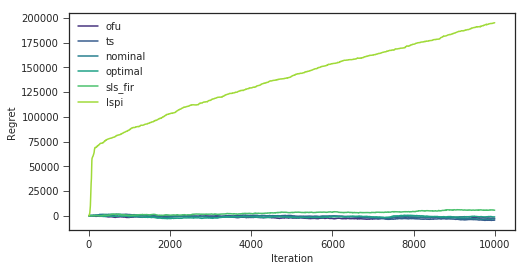

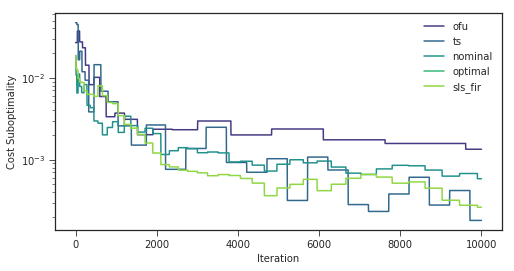

In [14]:
regretlist = []
costs_list = []

strat_rearranged =  [strategies[2], strategies[3], strategies[1], strategies[0], strategies[4], strategies[5]]
res_rearranged =  [list_of_results[2], list_of_results[3], list_of_results[1], list_of_results[0], list_of_results[4], list_of_results[5]]

for name, result in zip(strat_rearranged, res_rearranged):
    regrets, errors, costs, _, bad_invocations = result
    print(name, "bad_invocations", bad_invocations)
    percent_bad = bad_invocations / trials_per_method * 100
    regretlist.append(get_errorbars(regrets, q=10, percent_bad=percent_bad))
    costs_list.append(get_errorbars(costs, q=10, percent_bad=percent_bad))

sns.set_palette("muted")
plot_list_medquantile(regretlist, legendlist=strat_rearranged, xlabel="Iteration", ylabel="Regret")
plot_list_medquantile(costs_list[:-1], legendlist=strat_rearranged[:-1], xlabel="Iteration", 
                      ylabel="Cost Suboptimality", semilogy=True, loc='upper right')


In [69]:
list_of_results[-1][2]

array([[-0.96951615, -0.96951615, -0.96951615, ..., -0.96951615,
        -0.96951615, -0.96951615],
       [-0.96951615, -0.96951615, -0.96951615, ..., -0.96951615,
        -0.96951615, -0.96951615],
       [-0.96951615, -0.96951615, -0.96951615, ..., -0.96951615,
        -0.96951615, -0.96951615],
       [-0.96951615, -0.96951615, -0.96951615, ..., -0.96951615,
        -0.96951615, -0.96951615],
       [-0.96951615, -0.96951615, -0.96951615, ..., -0.96951615,
        -0.96951615, -0.96951615]])